In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc
import visualization_helper # Custom helper functions 
from PIL import Image # Converting image

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



2025-04-16 21:47:24.649822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744865244.717724    4700 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744865244.738369    4700 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744865244.885108    4700 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744865244.885154    4700 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744865244.885156    4700 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(f"GPU: {gpu.name}")
    print(details)


GPU: /physical_device:GPU:0
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3080 Ti'}


In [3]:
import subprocess

def print_gpu_memory():
    output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
    print(output)

print_gpu_memory()

Wed Apr 16 21:47:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 572.83       CUDA Version: 12.8     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  | 00000000:2B:00.0  On |                  N/A |
|  0%   37C    P8              37W / 370W |    996MiB / 12288MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    # axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0, 1, 2)  # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained("2D_versatile_he")
    labels, _ = model.predict_instances(
        img, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return labels

In [5]:
dir_base = (
    '/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/'
    'dietary_droject/data/Rose_Li_VisiumHD/'
    'BANOSSM_SSM0015_1_PR_Whole_C1_VISHD_F07833_22WJCYLT3/outs/spatial/'
)


filename = 'tissue_hires_image.png'

img_pil = Image.open(dir_base + filename).convert("RGB")
img_np = np.array(img_pil)

low_percentile = 0.5 # default 1
upper_percentile = 99.9 # default 99.8

# Normalize across all channels
img_norm = normalize(img_np, low_percentile, upper_percentile, axis=(0, 1, 2))
print(img_np.shape)


(6000, 5656, 3)


In [6]:
# from stardist.models import StarDist2D

# model = StarDist2D.from_pretrained("2D_versatile_he")
# # help(model.predict_instances)

In [7]:
# Run StarDist segmentation
model = StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.


I0000 00:00:1744865250.099461    4700 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [8]:
model_scale = 7#7       # Default values 1
nms_threshold = 0.1   # 0.3
prob_threshold = 0.3   #0.692478
labels, polys = model.predict_instances(img_norm,               
                                    scale= model_scale,     
                                    n_tiles = (20, 20, 1),  
                                    nms_thresh = nms_threshold,
                                    prob_thresh = prob_threshold,
                                    show_tile_progress=True)

functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
I0000 00:00:1744865416.934001    4880 service.cc:152] XLA service 0x7f33ac00c070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744865416.934036    4880 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-04-16 21:50:16.957001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744865417.032509    4880 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1744865418.771333    4880 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  0%|                                                                                       | 0/400 [00:00<?, ?it/s]funct

In [29]:
# Creating a list to store Polygon geometries
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

# Visualizing results

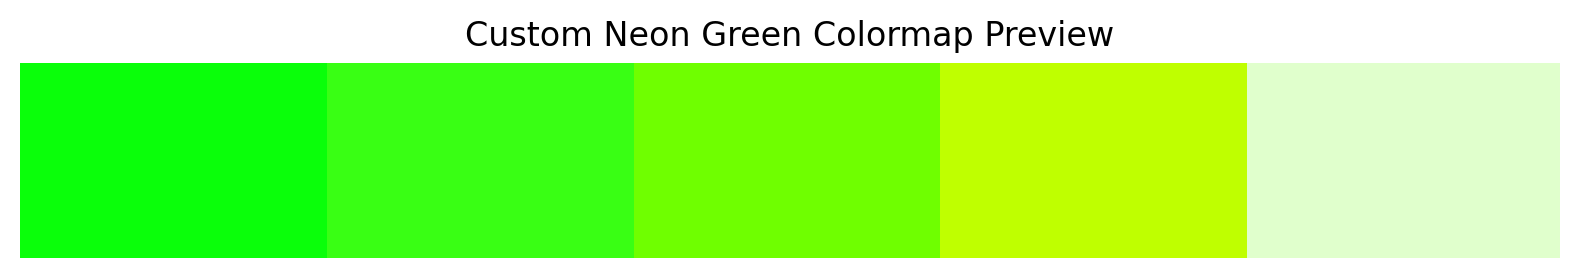

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define custom neon green colormap
neon_green = ListedColormap([
    "#0aff0a",  # neon green
    "#39ff14",  # electric lime
    "#6fff00",  # chartreuse green
    "#bfff00",  # lime yellow
    "#e0ffcc"   # pale green-white
])

# Create a simple gradient to show the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Plot the colormap
plt.figure(figsize=(8, 1.5))
plt.imshow(gradient, aspect='auto', cmap=neon_green)
plt.axis('off')
plt.title("Custom Neon Green Colormap Preview", fontsize=12)
plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt
import os

# Output directory
img_dir = (
    '/mnt/c/Users/jonan/Documents/1Work/RoseLab/'
    'Spatial/dietary_droject/figures/cell_segmentation/'
)
os.makedirs(img_dir, exist_ok=True)
filename = ('stardist_overlay_scale_' + str(model_scale) + '_' +
            str(low_percentile) + '_' + str(upper_percentile) + '_' + 
            str(nms_threshold) + '_' + str(prob_threshold) + '.png'
           )
output_path = os.path.join(img_dir, filename)

# output_path = os.path.join(img_dir, 'stardist_overlay_scale_', model_scale, '.png')

# === Parameters to TUNE ===
segmentation_alpha = 0.22  # transparency of segmentation (0 = fully transparent, 1 = fully opaque)
cmap_segmentation = 'jet'  # you can change this if you prefer other color schemes

# === Plot H&E background and segmentation overlay ===
plt.figure(figsize=(15, 15))
plt.imshow(img_np)  # show H&E image
plt.imshow(labels, cmap=cmap_segmentation, alpha=segmentation_alpha)  # overlay with alpha
plt.axis('off')
plt.title("StarDist Segmentation Over H&E")

# Save high-resolution overlay image
plt.savefig(output_path, dpi=1200, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Overlay saved at:\n{output_path}")


Overlay saved at:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/figures/cell_segmentation/stardist_overlay_scale_7_0.5_99.9_0.1_0.3.png


In [23]:
import tifffile

#Save labels
labels_output = ("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
                 "dietary_droject/data/cell_segmentation/"
                 "Testing/nuclei_labels_7_0.5_99.9_0.1_0.3.tif")
tifffile.imwrite(labels_output, labels.astype('uint16'))

# saving polygon info
import pickle

polys_output = labels_output.replace(".tif", "_polys.pkl")
with open(polys_output, "wb") as f:
    pickle.dump(polys, f)


# Saving metadata

import json

params = {
    "scale": model_scale,
    "nms_threshold": nms_threshold,
    "prob_threshold": prob_threshold,
    "image_shape": img_np.shape
}
json_output = labels_output.replace(".tif", "_params.json")
with open(json_output, "w") as f:
    json.dump(params, f, indent=4)


# # Loading later
# import tifffile
# import pickle

# # Load label mask
# labels = tifffile.imread(labels_output)

# # Load polygon data
# with open(polys_output, "rb") as f:
#     polys = pickle.load(f)


# Binning Visium HD Gene Expression Data

In [30]:
spatial_dir_base = (
    "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/"
    "data/Rose_Li_VisiumHD/BANOSSM_SSM0015_1_PR_Whole_C1_VISHD_F07833_22WJCYLT3/"
    "outs/binned_outputs/square_002um/"
)
# os.path.join()
# Load Visium HD data
raw_h5_file = spatial_dir_base+'filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(raw_h5_file)
adata.var_names_make_unique()

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
# Loading tissue parquet
tissue_position_file = os.path.join(spatial_dir_base, "spatial", 'tissue_positions.parquet')
df_tissue_positions=pd.read_parquet(tissue_position_file)

In [32]:
#Set the index of the dataframe to the barcodes
df_tissue_positions = df_tissue_positions.set_index('barcode')

# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

# Adding the tissue positions to the meta data
adata.obs =  pd.merge(adata.obs, df_tissue_positions, left_index=True, right_index=True)

# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(df_tissue_positions['pxl_col_in_fullres'], df_tissue_positions['pxl_row_in_fullres'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [33]:
# Perform a spatial join to check which coordinates are in a cell nucleus
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])
filtered_adata = adata[filtered_obs_mask,:]

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry','id','is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [34]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


storemagic.py (229): This is now an optional IPython functionality, setting autorestore/grouped_filtered_adata requires you to install the `pickleshare` library.


# Saving file

In [64]:
from pathlib import Path

def ensure_dir(path):
    """Create the directory if it doesn't exist."""
    path = Path(path)
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")

In [70]:
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData")
sample_name = "F07833"

output_root = segmentation_path / sample_name
mdl_output = output_root / "model_output"
fig_output = output_root / "figures"

ensure_dir(output_root)
ensure_dir(mdl_output)
ensure_dir(fig_output)


Directory already exists: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833
Directory already exists: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/model_output
Directory already exists: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures


In [61]:
output_root

PosixPath('/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833')

In [ ]:
from pathlib import Path
import tifffile
import pickle
import json
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
sample_name = "F07833"
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData")
output_root = segmentation_path / sample_name
mdl_output = output_root / "model_output"
fig_output = output_root / "figures"

# Ensure folders exist
for path in [output_root, mdl_output, fig_output]:
    path.mkdir(parents=True, exist_ok=True)

# --- Save model output ---
labels_file = mdl_output / f"{sample_name}_labels.tif"
tifffile.imwrite(labels_file, labels.astype("uint16"))

polys_file = mdl_output / f"{sample_name}_polys.pkl"
with open(polys_file, "wb") as f:
    pickle.dump(polys, f)

params = {
    "model": "2D_versatile_he",
    "scale": model_scale,
    "nms_threshold": nms_threshold,
    "prob_threshold": prob_threshold,
    "low_percentile": low_percentile,
    "upper_percentile": upper_percentile,
    "image_shape": img_np.shape
}
params_file = mdl_output / f"{sample_name}_params.json"
with open(params_file, "w") as f:
    json.dump(params, f, indent=4)

# --- Save figures ---
hne_file = fig_output / f"{sample_name}_hne_image.png"
Image.fromarray(img_np).save(hne_file)

overlay_file = fig_output / f"{sample_name}_overlay.png"
plt.figure(figsize=(15, 15))
plt.imshow(img_np)
plt.imshow(labels, cmap="jet", alpha=0.22)
plt.axis("off")
plt.title("StarDist Segmentation Over H&E")
plt.savefig(overlay_file, dpi=1200, bbox_inches="tight", pad_inches=0)
plt.close()

polygon_file = fig_output / f"{sample_name}_polygons.geojson"
gdf.to_file(polygon_file, driver='GeoJSON')

In [69]:
# --- Save final analysis outputs ---
# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area
gdf_file = output_root / f"{sample_name}_gdf.gpkg"
gdf.to_file(gdf_file, driver='GPKG')

adata_file = output_root / f"{sample_name}_grouped_filtered_adata.h5ad"
grouped_filtered_adata.write(adata_file)

print(f"✅ All outputs saved in: {output_root}")

geopandas.py (662): 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.


✅ All outputs saved in: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833


In [44]:
from pathlib import Path

# File path to create
file_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData")

file_name = file_path / 'F07833_segmented.h5ad'

if not file_path.exists():
    print(f'{file_path} does not exists')
    # Ensure directory exists
    file_name.parent.mkdir(parents=True, exist_ok=True)

grouped_filtered_adata.write(file_name)
                           

In [45]:
from pathlib import Path
import tifffile
import json
import pickle

# === Define save paths ===
output_root = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833")
output_root.mkdir(parents=True, exist_ok=True)

sample_id = "F07833"

# === Save final AnnData ===
grouped_filtered_adata.write(output_root / f"{sample_id}_segmented.h5ad")

# === Save label mask ===
label_path = output_root / f"{sample_id}_nuclei_labels_scale_{model_scale}_{low_percentile}_{upper_percentile}_{nms_threshold}_{prob_threshold}.tif"
tifffile.imwrite(label_path, labels.astype("uint16"))

# === Save polygon data ===
poly_path = label_path.with_name(label_path.stem + "_polys.pkl")
with open(poly_path, "wb") as f:
    pickle.dump(polys, f)

# === Save segmentation metadata ===
params = {
    "model": "2D_versatile_he",
    "scale": model_scale,
    "nms_threshold": nms_threshold,
    "prob_threshold": prob_threshold,
    "low_percentile": low_percentile,
    "upper_percentile": upper_percentile,
    "image_shape": img_np.shape
}
param_path = label_path.with_name(label_path.stem + "_params.json")
with open(param_path, "w") as f:
    json.dump(params, f, indent=4)

# === Save segmentation polygons as GeoJSON ===
gdf.to_file(output_root / f"{sample_id}_nuclei_polygons.geojson", driver="GeoJSON")

# === Save overlay image ===
import matplotlib.pyplot as plt

overlay_path = output_root / f"{sample_id}_stardist_overlay.png"
plt.figure(figsize=(12, 12))
plt.imshow(img_np)
plt.imshow(labels, cmap="jet", alpha=0.22)
plt.axis("off")
plt.title(f"StarDist Segmentation Overlay - {sample_id}")
plt.savefig(overlay_path, dpi=300, bbox_inches="tight", pad_inches=0)
plt.close()

print(f"All outputs saved in:\n{output_root.resolve()}")


geopandas.py (662): 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.


All outputs saved in:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833


# Learning the data

In [47]:
polys['coord'][1][0] 

array([1132.5714, 1133.106 , 1133.6461, 1134.1134, 1134.5668, 1134.9294,
       1135.2539, 1135.4575, 1135.6609, 1135.5247, 1135.3622, 1135.0054,
       1134.5428, 1134.0656, 1133.5632, 1133.0524, 1132.5714, 1132.0868,
       1131.5869, 1131.112 , 1130.6467, 1130.2533, 1129.9093, 1129.7448,
       1129.5984, 1129.7028, 1129.8638, 1130.1498, 1130.5223, 1130.9817,
       1131.4729, 1132.0275], dtype=float32)

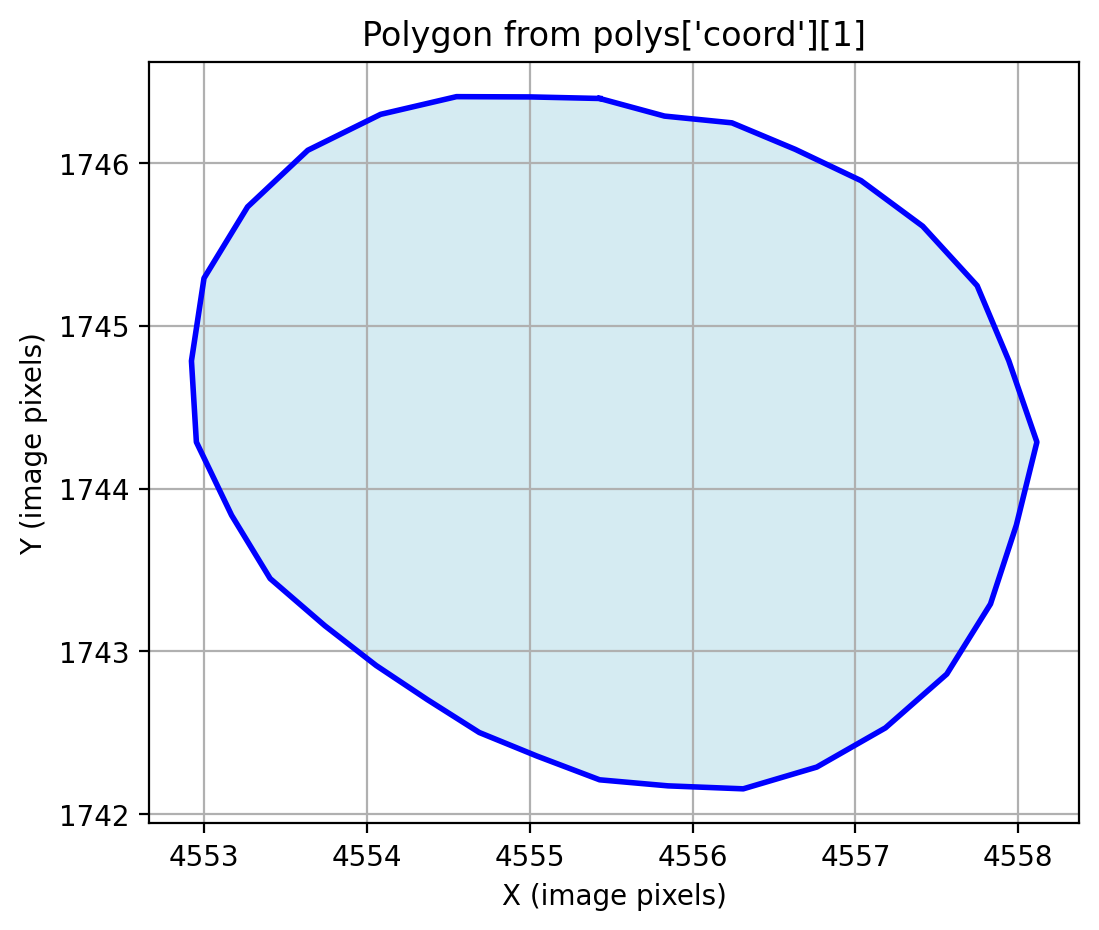

In [50]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Extract the polygon coordinates for the second nucleus (index 1)
x_coords = polys['coord'][3000][0]
y_coords = polys['coord'][3000][1]

# Create the polygon (note: order as (x, y) if visualizing in standard plot)
coords = list(zip(x_coords, y_coords))
poly = Polygon(coords)

# Plot the polygon
fig, ax = plt.subplots(figsize=(6, 6))

# Extract the exterior (outline) of the polygon
x_poly, y_poly = poly.exterior.xy

# Plot the polygon
ax.plot(x_poly, y_poly, color='blue', linewidth=2)
ax.fill(x_poly, y_poly, color='lightblue', alpha=0.5)

# Set equal aspect ratio for correct shape
ax.set_aspect("equal")
ax.set_title("Polygon from polys['coord'][1]")
plt.xlabel("X (image pixels)")
plt.ylabel("Y (image pixels)")
plt.grid(True)
plt.show()


In [52]:
len(polys['coord'])/4

67442.75

# Geometry file

In [55]:
gdf

,geometry,id
0,"POLYGON ((4883.675 504, 4883.576 504.541, 4883...",ID_1
1,"POLYGON ((3770.518 1132.571, 3770.401 1133.106...",ID_2
2,"POLYGON ((1671.726 4057.428, 1671.705 4057.881...",ID_3
3,"POLYGON ((4460.981 612.857, 4460.879 613.373, ...",ID_4
4,"POLYGON ((5118.552 4105.714, 5118.474 4106.149...",ID_5
...,...,...
269766,"POLYGON ((5278.386 5230.286, 5278.492 5230.667...",ID_269767
269767,"POLYGON ((2808.223 2548.857, 2808.217 2549.128...",ID_269768
269768,"POLYGON ((4180.484 5009.143, 4180.265 5009.537...",ID_269769
269769,"POLYGON ((4253.084 5182.857, 4252.883 5183.146...",ID_269770


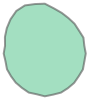

In [54]:
gdf['geometry'][0]

<Axes: >

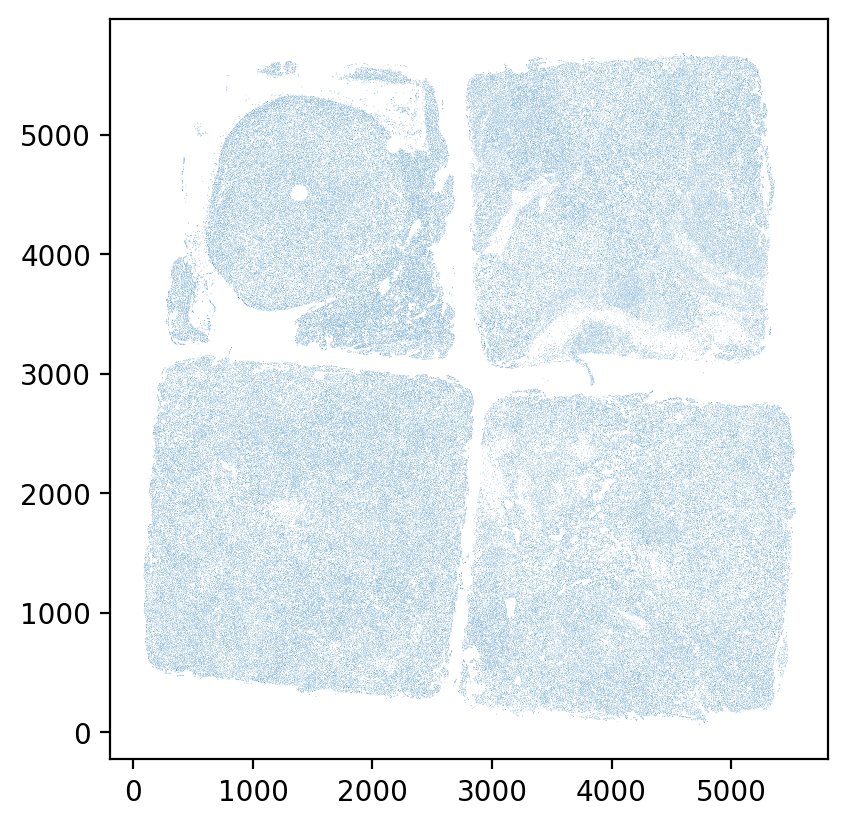

In [56]:
gdf.plot(ax=plt.gca()) 


# Tissue positions

In [57]:
df_tissue_positions

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,index
barcode,,,,,,
s_002um_00000_00000-1,0,0,0,10850.664901,999.164225,s_002um_00000_00000-1
s_002um_00000_00001-1,0,0,1,10850.645398,1002.072490,s_002um_00000_00001-1
s_002um_00000_00002-1,0,0,2,10850.625895,1004.980755,s_002um_00000_00002-1
s_002um_00000_00003-1,0,0,3,10850.606392,1007.889020,s_002um_00000_00003-1
s_002um_00000_00004-1,0,0,4,10850.586889,1010.797285,s_002um_00000_00004-1
...,...,...,...,...,...,...
s_002um_03349_03345-1,1,3349,3345,1045.753117,10662.121430,s_002um_03349_03345-1
s_002um_03349_03346-1,1,3349,3346,1045.733552,10665.029782,s_002um_03349_03346-1
s_002um_03349_03347-1,1,3349,3347,1045.713988,10667.938135,s_002um_03349_03347-1
